# How to pass runtime values to tools

This guide shows how to define tools that depend on dynamically defined variables. These values are provided by your program, not by the LLM.

Tools can access the [config.configurable](https://langchain-ai.github.io/langgraphjs/reference/interfaces/langgraph.LangGraphRunnableConfig.html) field for values like user IDs that are known when a graph is initially executed, as well as managed values from the [store](https://langchain-ai.github.io/langgraphjs/reference/classes/checkpoint.BaseStore.html) for persistence across threads.

However, it can be convenient to access intermediate runtime values which are not known ahead of time, but are progressively generated as a graph executes, such as the current graph state. This guide will cover two techniques for this: The `getCurrentTaskInput` utility function, and closures.

## Setup

Install the following to run this guide:

```bash
npm install @langchain/langgraph @langchain/openai @langchain/core
```

Next, configure your environment to connect to your model provider.

```bash
export OPENAI_API_KEY=your-api-key
```

Optionally, set your API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

```bash
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_CALLBACKS_BACKGROUND="true"
export LANGCHAIN_API_KEY=your-api-key
```

## The `getCurrentTaskInput` Utility Function

The `getCurrentTaskInput` utility function makes it easier to get the current state in areas of your application that might be called indirectly, like tool handlers.

<div class="admonition tip">
    <p class="admonition-title">Compatibility</p>
    <p>
        This functionality was added in <code>@langchain/langgraph>=0.2.53</code>.
    </p>
    <p>
        It also requires <a href="https://nodejs.org/api/async_hooks.html"><code>async_hooks</code></a> support, which is supported in many popular JavaScript environments (such as Node.js, Deno, and Cloudflare Workers), but not all of them (mainly web browsers). If you are deploying to an environment where this is not supported, see the [closures](#closures) section below.
    </p>
</div>


Let's start off by defining a tool that an LLM can use to update pet preferences for a user. The tool will retrieve the current state of the graph from the current context.

### Define the agent state

Since we're just tracking messages, we'll use the `MessagesAnnotation`:

In [1]:
import { MessagesAnnotation } from "@langchain/langgraph";

Now, declare a tool as shown below. The tool receives values in three different ways:

1. It will receive a generated list of `pets` from the LLM in its `input`.
2. It will pull a `userId` populated from the initial graph invocation.
3. It will fetch the input that was passed to the currenty executing task (either a `StateGraph` node handler, or a Functional API `entrypoint` or `task`) via the `getCurrentTaskInput` function.

It will then use LangGraph's [cross-thread persistence](https://langchain-ai.github.io/langgraphjs/how-tos/cross-thread-persistence/) to save preferences:

In [2]:
import { z } from "zod";
import { tool } from "@langchain/core/tools";
import {
  getCurrentTaskInput,
  LangGraphRunnableConfig,
} from "@langchain/langgraph";

const updateFavoritePets = tool(async (input, config: LangGraphRunnableConfig) => {
  // Some arguments are populated by the LLM; these are included in the schema below
  const { pets } = input;
  // Fetch the current input to the task that called this tool.
  // This will be identical to the input that was passed to the `ToolNode` that called this tool.
  const currentState = getCurrentTaskInput() as typeof MessagesAnnotation.State;
  // Other information (such as a UserID) are most easily provided via the config
  // This is set when when invoking or streaming the graph
  const userId = config.configurable?.userId;
  // LangGraph's managed key-value store is also accessible from the config
  const store = config.store;
  await store.put([userId, "pets"], "names", pets);
  // Store the initial input message from the user as a note.
  // Using the same key will override previous values - you could
  // use something different if you wanted to store many interactions.
  await store.put([userId, "pets"], "context", { content: currentState.messages[0].content });

  return "update_favorite_pets called.";
},
{
  // The LLM "sees" the following schema:
  name: "update_favorite_pets",
  description: "add to the list of favorite pets.",
  schema: z.object({
    pets: z.array(z.string()),
  }),
});

If we look at the tool call schema, which is what is passed to the model for tool-calling, we can see that only `pets` is being passed:

In [3]:
import { zodToJsonSchema } from "zod-to-json-schema";

console.log(zodToJsonSchema(updateFavoritePets.schema));

{
  type: 'object',
  properties: { pets: { type: 'array', items: [Object] } },
  required: [ 'pets' ],
  additionalProperties: false,
  '$schema': 'http://json-schema.org/draft-07/schema#'
}


Let's also declare another tool so that our agent can retrieve previously set preferences:

In [4]:
const getFavoritePets = tool(
  async (_, config: LangGraphRunnableConfig) => {
    const userId = config.configurable?.userId;
    // LangGraph's managed key-value store is also accessible via the config
    const store = config.store;
    const petNames = await store.get([userId, "pets"], "names");
    const context = await store.get([userId, "pets"], "context");
    return JSON.stringify({
      pets: petNames.value,
      context: context.value.content,
    });
  },
  {
    // The LLM "sees" the following schema:
    name: "get_favorite_pets",
    description: "retrieve the list of favorite pets for the given user.",
    schema: z.object({}),
  }
);

## Define the nodes

From here there's really nothing special that needs to be done. This approach works with both `StateGraph` and functional agents, and it works just as well with prebuilt agents like `createReactAgent`! We'll demonstrate it by defining a custom ReAct agent using `StateGraph`. This is very similar to the agent that you'd get if you were to instead call [`createReactAgent`](../reference/functions/langgraph_prebuilt.createReactAgent.html)

Let's start off by defining the nodes for our graph.

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.

1. After the agent is called, we should either invoke the tool node or finish.
2. After the tool node have been invoked, it should always go back to the agent to decide what to do next

In [5]:
import {
  END,
  START,
  StateGraph,
  MemorySaver,
  InMemoryStore,
} from "@langchain/langgraph";
import { AIMessage } from "@langchain/core/messages";
import { ToolNode } from "@langchain/langgraph/prebuilt";
import { ChatOpenAI } from "@langchain/openai";

const model = new ChatOpenAI({ model: "gpt-4o" });

const tools = [getFavoritePets, updateFavoritePets];

const routeMessage = (state: typeof MessagesAnnotation.State) => {
  const { messages } = state;
  const lastMessage = messages[messages.length - 1] as AIMessage;
  // If no tools are called, we can finish (respond to the user)
  if (!lastMessage?.tool_calls?.length) {
    return END;
  }
  // Otherwise if there is, we continue and call the tools
  return "tools";
};

const callModel = async (state: typeof MessagesAnnotation.State) => {
  const { messages } = state;
  const modelWithTools = model.bindTools(tools);
  const responseMessage = await modelWithTools.invoke([
    {
      role: "system",
      content: "You are a personal assistant. Store any preferences the user tells you about."
    },
    ...messages
  ]);
  return { messages: [responseMessage] };
};

const workflow = new StateGraph(MessagesAnnotation)
  .addNode("agent", callModel)
  .addNode("tools", new ToolNode(tools))
  .addEdge(START, "agent")
  .addConditionalEdges("agent", routeMessage)
  .addEdge("tools", "agent");

const memory = new MemorySaver();
const store = new InMemoryStore();

const graph = workflow.compile({ checkpointer: memory, store: store });

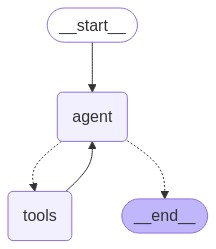

In [7]:
import * as tslab from "tslab";

const graphViz = graph.getGraph();
const image = await graphViz.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## Use it!

Let's use our graph now!

In [8]:
import {
  BaseMessage,
  isAIMessage,
  isHumanMessage,
  isToolMessage,
  HumanMessage,
  ToolMessage,
} from "@langchain/core/messages";

let inputs = {
  messages: [ new HumanMessage({ content: "My favorite pet is a terrier. I saw a cute one on Twitter." }) ],
};

let config = {
  configurable: {
    thread_id: "1",
    userId: "a-user",
  },
};

function printMessages(messages: BaseMessage[]) {
  for (const message of messages) {
    if (isHumanMessage(message)) {
      console.log(`User: ${message.content}`);
    } else if (isAIMessage(message)) {
      const aiMessage = message as AIMessage;
      if (aiMessage.content) {
        console.log(`Assistant: ${aiMessage.content}`);
      }
      if (aiMessage.tool_calls) {
        for (const toolCall of aiMessage.tool_calls) {
          console.log(`Tool call: ${toolCall.name}(${JSON.stringify(toolCall.args)})`);
        }
      }
    } else if (isToolMessage(message)) {
      const toolMessage = message as ToolMessage;
      console.log(`${toolMessage.name} tool output: ${toolMessage.content}`);
    }
  }
}

let { messages } = await graph.invoke(inputs, config);

printMessages(messages);


User: My favorite pet is a terrier. I saw a cute one on Twitter.
Tool call: update_favorite_pets({"pets":["terrier"]})
update_favorite_pets tool output: update_favorite_pets called.
Assistant: I've added "terrier" to your list of favorite pets. If you have any more favorites, feel free to let me know!


Now verify it can properly fetch the stored preferences and cite where it got the information from:

In [9]:
inputs = { messages: [new HumanMessage({ content: "What're my favorite pets and what did I say when I told you about them?" })] };
config = {
  configurable: {
    thread_id: "2", // New thread ID, so the conversation history isn't present.
    userId: "a-user"
  }
};

messages = (await graph.invoke(inputs, config)).messages;

printMessages(messages);

User: What're my favorite pets and what did I say when I told you about them?
Tool call: get_favorite_pets({})
get_favorite_pets tool output: {"pets":["terrier"],"context":"My favorite pet is a terrier. I saw a cute one on Twitter."}
Assistant: Your favorite pet is a terrier. You mentioned, "My favorite pet is a terrier. I saw a cute one on Twitter."


As you can see the agent is able to properly cite that the information came from Twitter!

## Closures

If you cannot use context variables in your environment, you can use [closures](https://developer.mozilla.org/en-US/docs/Web/JavaScript/Closures) to create tools with access to dynamic content. Here is a high-level example:

In [10]:
function generateTools(state: typeof MessagesAnnotation.State) {
  const updateFavoritePets = tool(
    async (input, config: LangGraphRunnableConfig) => {
      // Some arguments are populated by the LLM; these are included in the schema below
      const { pets } = input;
      // Others (such as a UserID) are best provided via the config
      // This is set when when invoking or streaming the graph
      const userId = config.configurable?.userId;
      // LangGraph's managed key-value store is also accessible via the config
      const store = config.store;
      await store.put([userId, "pets"], "names", pets )
      await store.put([userId, "pets"], "context", {content: state.messages[0].content})

      return "update_favorite_pets called.";
    },
    {
      // The LLM "sees" the following schema:
      name: "update_favorite_pets",
      description: "add to the list of favorite pets.",
      schema: z.object({
        pets: z.array(z.string()),
      }),
    }
  );
  return [updateFavoritePets];
};

Then, when laying out your graph, you will need to call the above method whenever you bind or invoke tools. For example:

In [11]:
const toolNodeWithClosure = async (state: typeof MessagesAnnotation.State) => {
  // We fetch the tools any time this node is reached to
  // form a closure and let it access the latest messages
  const tools = generateTools(state);
  const toolNodeWithConfig = new ToolNode(tools);
  return toolNodeWithConfig.invoke(state);
};